В нотбуке проект разбит на составляющие для более удобного отображения, комментарии в коде написаны на английском для избежания проблем с переключением языка
Некоторые ячейки выполнены с разных гугл аккаунтов, тк у основного закончился лимит на GPU

---



### Объединение импортов




In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Convolution2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from keras.applications import VGG16, VGG19
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from keras_preprocessing import image
from keras.models import Sequential, Model, load_model
from keras import metrics
from keras.applications import resnet, resnet_v2, densenet, mobilenet, mobilenet_v2
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, AveragePooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate, ZeroPadding2D, ReLU, DepthwiseConv2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras import regularizers
from keras.constraints import max_norm, min_max_norm
import tensorflow as tf
import numpy as np
import random as rand
from PIL import Image
import numpy as np
import random
import io, os, sys
import time, datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Загрузка данных

In [ ]:
key = 1
data_prop = {
    1: {'train': '/content/drive/MyDrive/nnw/arc/train', 
        'test':  '/content/drive/MyDrive/nnw/arc/test',
        'labels': ('Gothic architecture', 'Palladian architecture', 'Russian Revival architecture',
          'Romanesque architecture', 'Greek Revival architecture', 'Tudor Revival architecture', 'Novelty architecture',
          'Queen Anne architecture', 'Postmodern architecture', 'International style', 'Deconstructivism', 
          'Beaux-Arts architecture', 'Georgian architecture',  'Baroque architecture',
          'Colonial architecture', 'Chicago school architecture', 'Ancient Egyptian architecture',
          'American craftsman style', 'Art Deco architecture'),
        'num_classes': 19,
        # batch size
        'batch_size': 30,
        # train set size
        'nb_train_samples': 2530,
        # validation set size 
        'nb_validation_samples': 833,
        # test set size
        'nb_test_samples': 833}, 
    2: {
        'train': '/content/drive/MyDrive/nnw/heritage/train', 
        'test':  '/content/drive/MyDrive/nnw/heritage/test',
        'labels': ['altar','apse','bell_tower','column','dome(inner)','dome(outer)','flying_buttress','gargoyle',
                      'stained_glass','vault'],
        'num_classes': 10, 
        'SEED': 1, 
        'batch_size': 30,
        'nb_train_samples': 4999,
        'nb_validation_samples': 519,
        'nb_test_samples': 519},
    3: {
        'train': '/content/drive/MyDrive/nnw/MonuMAI/train', 
        'test':  '/content/drive/MyDrive/nnw/MonuMAI/test',
        'labels': ['Renaissance', 'Hispanic-Muslim', 'Gothic', 'Baroque'],
        'num_classes': 4,
        'batch_size': 30,
        'nb_train_samples': 1059,
        'nb_validation_samples': 322,
        'nb_test_samples': 322
    }
}

### Классификайия стилей 1
Основано на материалах с курса по мл за семестр
Использовались разные архитектуры для классификатора, последняя по очереди - использована в сохраненной и доступной к загрузке модели - показавшая лучшие результаты по точности

In [ ]:
# shape of the RGB image
img_width, img_height, channels = 150, 150, 3
batch_size = 30
# input shape
input_shape = (img_width, img_height, 3)



In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    data_prop[key]['train'],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    data_prop[key]['test'],
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')
train_generator.classes

Found 2526 images belonging to 19 classes.
Found 830 images belonging to 19 classes.


array([ 0,  0,  0, ..., 18, 18, 18], dtype=int32)

In [ ]:
# labels in colab were kinda random, so here classes as they are
train_generator.class_indices

{'American craftsman style': 0,
 'Ancient Egyptian architecture': 1,
 'Art Deco architecture': 2,
 'Baroque architecture': 3,
 'Beaux-Arts architecture': 4,
 'Chicago school architecture': 5,
 'Colonial architecture': 6,
 'Deconstructivism': 7,
 'Georgian architecture': 8,
 'Gothic architecture': 9,
 'Greek Revival architecture': 10,
 'International style': 11,
 'Novelty architecture': 12,
 'Palladian architecture': 13,
 'Postmodern architecture': 14,
 'Queen Anne architecture': 15,
 'Romanesque architecture': 16,
 'Russian Revival architecture': 17,
 'Tudor Revival architecture': 18}

In [ ]:
classes_dict = {value : key for (key, value) in train_generator.class_indices.items()}
classes_dict

{0: 'American craftsman style',
 1: 'Ancient Egyptian architecture',
 2: 'Art Deco architecture',
 3: 'Baroque architecture',
 4: 'Beaux-Arts architecture',
 5: 'Chicago school architecture',
 6: 'Colonial architecture',
 7: 'Deconstructivism',
 8: 'Georgian architecture',
 9: 'Gothic architecture',
 10: 'Greek Revival architecture',
 11: 'International style',
 12: 'Novelty architecture',
 13: 'Palladian architecture',
 14: 'Postmodern architecture',
 15: 'Queen Anne architecture',
 16: 'Romanesque architecture',
 17: 'Russian Revival architecture',
 18: 'Tudor Revival architecture'}

In [ ]:
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(150, 150, 3))
vgg16_net.trainable = False 
model = Sequential()
model.add(vgg16_net)

# + flattening
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
# + Dropout
model.add(Dropout(0.1))
# to our classes
model.add(Dense(data_prop[key]['num_classes'], activation='sigmoid'))
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 23,108,420
Trainable params: 8,393,732
Non-

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5),
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=data_prop[key]['nb_train_samples'] // data_prop[key]['batch_size'],
    epochs=25,
    validation_data= test_generator,
    validation_steps=data_prop[key]['nb_validation_samples'] // data_prop[key]['batch_size'])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
35/35 [==============================] - 1163s 33s/step - loss: 0.6555 - accuracy: 0.2861 - val_loss: 0.5153 - val_accuracy: 0.4933
Epoch 2/25
35/35 [==============================] - 35s 995ms/step - loss: 0.4992 - accuracy: 0.5301 - val_loss: 0.4752 - val_accuracy: 0.5467
Epoch 3/25
35/35 [==============================] - 35s 987ms/step - loss: 0.4471 - accuracy: 0.6472 - val_loss: 0.4477 - val_accuracy: 0.6233
Epoch 4/25
35/35 [==============================] - 35s 1000ms/step - loss: 0.4155 - accuracy: 0.6828 - val_loss: 0.4235 - val_accuracy: 0.6467
Epoch 5/25
35/35 [==============================] - 35s 1s/step - loss: 0.3844 - accuracy: 0.7193 - val_loss: 0.4122 - val_accuracy: 0.6533
Epoch 6/25
35/35 [==============================] - 35s 1s/step - loss: 0.3632 - accuracy: 0.7503 - val_loss: 0.3983 - val_accuracy: 0.6667
Epoch 7/25
35/35 [==============================] - 35s 1s/step - loss: 0.3312 - accuracy: 0.8123 - val_loss: 0.3945 - val_accuracy: 0.6633
Epoch 8

In [ ]:
model.save('classifier_with_vgg16_3.h5')

In [ ]:
# also available: - some of first models that weren`t that good
model = load_model('/content/drive/MyDrive/nnw/models/classifier_with_vgg16.h5')

In [ ]:
result

array([[2.0022573e-37, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)

### 2 

In [ ]:
# diffrernt parameters were use for Convolution2D, Activation, Dropout and  Dense, but acuracy on test data never got better then 50% 
# it wasn`t used for final model
model = Sequential(name='classifier')
model.add(Convolution2D(150, 3, 3, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.8))
model.add(MaxPooling2D(pool_size=(4, 4), input_shape=input_shape))
model.add(Flatten())
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(19))
model.add(Activation('softmax'))


### 3

In [ ]:
model = Sequential(name='classifier')
model.add(BatchNormalization(axis = 3))
model.add(Convolution2D(filters = 150, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add(Convolution2D(filters = 150, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(BatchNormalization(axis = 3))
model.add(Convolution2D(filters = 300, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add(Convolution2D(filters = 300, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add(MaxPooling2D())

model.add(BatchNormalization(axis = 3))
model.add(Convolution2D(filters = 600, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add(Convolution2D(filters = 600, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add(MaxPooling2D())
    
model.add(BatchNormalization(axis = 3))
model.add(Convolution2D(filters = 1200, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add(Convolution2D(filters = 1200, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add(MaxPooling2D())

model.add(BatchNormalization(axis = 3))
model.add(Convolution2D(filters = 600, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add(MaxPooling2D())

model.add(BatchNormalization(axis = 3))
model.add(Convolution2D(filters = 300, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(BatchNormalization(axis = 3))
model.add(Convolution2D(filters = 150, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                      activation='elu', kernel_initializer='random_uniform',
                      bias_constraint=min_max_norm(min_value=0.0, max_value=2.0)))
model.add( GlobalAveragePooling2D() )

model.add(Dense(150, activation = 'elu') )
model.add(Dense(data_prop[key]['num_classes'], activation = 'softmax') )
model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
              metrics=['accuracy'])

### 4

### 5

### res

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=data_prop[key]['nb_train_samples'] // data_prop[key]['batch_size'],
    epochs=25,
    validation_data= test_generator,
    validation_steps=data_prop[key]['nb_validation_samples'] // data_prop[key]['batch_size'])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
84/84 [==============================] - 2630s 31s/step - loss: 2.8421 - accuracy: 0.1505 - val_loss: 7.7124 - val_accuracy: 0.0568
Epoch 2/25
84/84 [==============================] - 46s 550ms/step - loss: 2.2766 - accuracy: 0.2870 - val_loss: 3.3786 - val_accuracy: 0.1975
Epoch 3/25
84/84 [==============================] - 46s 549ms/step - loss: 1.8724 - accuracy: 0.3924 - val_loss: 2.4373 - val_accuracy: 0.3407
Epoch 4/25
84/84 [==============================] - 46s 550ms/step - loss: 1.5511 - accuracy: 0.5039 - val_loss: 2.6241 - val_accuracy: 0.3346
Epoch 5/25
84/84 [==============================] - 46s 550ms/step - loss: 1.2121 - accuracy: 0.5836 - val_loss: 2.2829 - val_accuracy: 0.4136
Epoch 6/25
84/84 [==============================] - 46s 551ms/step - loss: 0.9991 - accuracy: 0.6674 - val_loss: 2.2340 - val_accuracy: 0.3827
Epoch 7/25
84/84 [==============================] - 46s 548ms/step - loss: 0.8619 - accuracy: 0.7235 - val_loss: 2.1104 - val_accuracy: 0.4630

In [ ]:
scores = model.evaluate_generator(test_generator, data_prop[key]['nb_test_samples'] // batch_size)
print(scores)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[2.2462308406829834, 0.5728394985198975]


In [ ]:
data_prop[key]

{'batch_size': 30,
 'labels': ('Gothic architecture',
  'Palladian architecture',
  'Russian Revival architecture',
  'Romanesque architecture',
  'Greek Revival architecture',
  'Tudor Revival architecture',
  'Novelty architecture',
  'Queen Anne architecture',
  'Postmodern architecture',
  'International style',
  'Deconstructivism',
  'Beaux-Arts architecture',
  'Georgian architecture',
  'Baroque architecture',
  'Colonial architecture',
  'Chicago school architecture',
  'Ancient Egyptian architecture',
  'American craftsman style',
  'Art Deco architecture'),
 'nb_test_samples': 833,
 'nb_train_samples': 2530,
 'nb_validation_samples': 833,
 'num_classes': 19,
 'test': '/content/drive/MyDrive/nnw/arc/test',
 'train': '/content/drive/MyDrive/nnw/arc/train'}

In [ ]:
model.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_56 (Batc (None, None, None, 3)     12        
_________________________________________________________________
conv2d_88 (Conv2D)           (None, None, None, 150)   4200      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, None, None, 150)   202650    
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, None, None, 150)   0         
_________________________________________________________________
dropout_74 (Dropout)         (None, None, None, 150)   0         
_________________________________________________________________
batch_normalization_57 (Batc (None, None, None, 150)   600       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, None, None, 300)   4

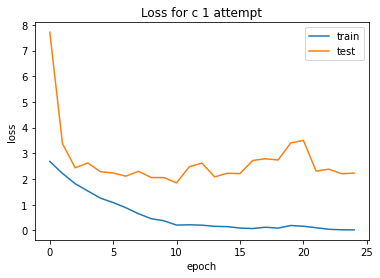

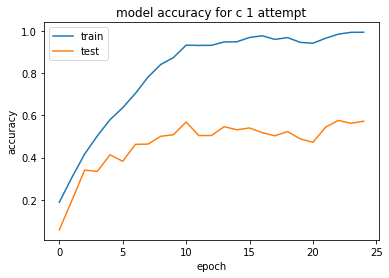

In [ ]:
n = 'c 1'
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Loss for {n} attempt')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig( f"test{n}.png")
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'model accuracy for {n} attempt')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig( f"test{n}_.png")
plt.show()

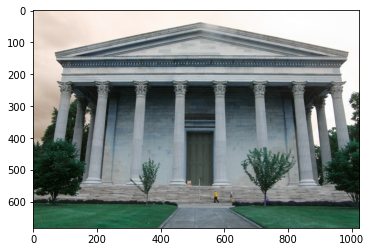

In [ ]:
# let`s see results for picture, that wasn`t shown to model before
import urllib
import numpy as np
# here some links to internet pictures
req = urllib.request.urlopen(
    #'https://sun9-40.userapi.com/impg/afdqXUHN7S50ZFtr9GtEan-Wv0CDCBdLfHEgQw/OrgDHrM0FCI.jpg?size=1024x1024&quality=96&proxy=1&sign=b00a8fc4f6e69c65fd7cad93dee84b1f&type=album')
    #'https://sun9-2.userapi.com/impg/yaeSWpbx26_S6uck4qDlRvnJ-gYTw72gxD-VnA/AMbyZITn5Tc.jpg?size=1024x1024&quality=96&proxy=1&sign=520db9f24ab9c2fb737b6ea1b4b3e9b5&type=album')
    #'https://inst-2.cdn.shockers.de/hs_cdn/out/pictures/master/product/1/gargoyle-mit-schwingen-auf-sockel-gargoyle-mit-fluegel-auf-saeule-38911-01.jpg')
     #   'https://static.giggster.com/images/location/c4ec7621-8bd6-4f2a-9e65-e585a3dbca5b/13bbca94-efb3-404f-98c7-949b1a679204/mid_x3.jpeg')
    #'https://static.elitsy.ru/media/cache/55/6b/556b4965fd0f2fbea46c1d4ae955f602.jpg')
    #'https://im0-tub-ru.yandex.net/i?id=49deae8cc3a178fe0fae4cf24f8b851c&n=13')
    #'https://i.pinimg.com/originals/55/4a/8c/554a8c86879ef52c6e9fa28b3a811116.jpg')
    #'https://i.pinimg.com/736x/05/1a/f0/051af0f2a54d874b1e4429aea216984c--tulsa-oklahoma-art-deco-style.jpg') #art deco 
    #'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQmP9TgLqJb5mEVezmjkNUn7bDs6jZZEbPbxA&usqp=CAU') # tudor revival
   # 'https://i.pinimg.com/originals/a1/d4/67/a1d467eedbc9b61f3cc1019050f65eb4.jpg') # Queen Anne architecture
    'http://4.bp.blogspot.com/_Gc6vdWbB2ZY/TT3d1leE0lI/AAAAAAAADoU/ttKyNKXjPnY/s1600/3641454175_920cdb4cd4_b.jpg') # Greek
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
plt.imshow(img)
img = cv2.resize(img, (150, 150))
img = np.reshape(img,[1, 150, 150, 3])


In [ ]:
#gettin first classes with best probability
result = model.predict(img)
n_classes = 5
best_classes = result.argsort()[0][::-1][:n_classes]
for i  in best_classes[-n_classes:]:
  print(f'{classes_dict[i]} - {result[0][i]}')

Greek Revival architecture - 1.0
Tudor Revival architecture - 0.0
Georgian architecture - 0.0
Ancient Egyptian architecture - 0.0
Art Deco architecture - 0.0
